# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

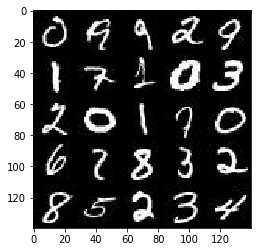

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

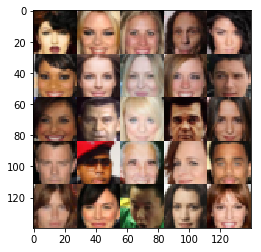

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # flatten
        _, width, height, depth = x3.get_shape().as_list()
        flattened = tf.reshape(relu3, (-1, width * height * depth))
        
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128
        
        # output layer
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='valid')
        # resize from 32x32x(out_channel_dim) to 28x28(xout_channel_dim)
        logits = tf.image.resize_images(x4, (28,28))
        
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # From DCGAN example in Lesson 5
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # From DCGAN example in Lesson 5
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    output_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                    
                    if steps % output_every == 0:
                        _ = show_generator_output(sess, 16, input_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.4356
Epoch 1/2... Discriminator Loss: 0.0955... Generator Loss: 4.0784
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 4.3203
Epoch 1/2... Discriminator Loss: 0.2306... Generator Loss: 2.4471
Epoch 1/2... Discriminator Loss: 0.5149... Generator Loss: 1.9781
Epoch 1/2... Discriminator Loss: 3.0736... Generator Loss: 0.0916
Epoch 1/2... Discriminator Loss: 0.9576... Generator Loss: 3.1236
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 1.4750
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 0.8263


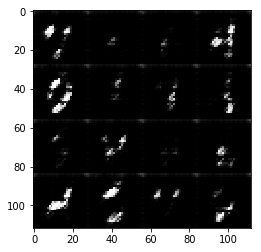

Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 4.6769
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 3.6283
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 5.5430
Epoch 1/2... Discriminator Loss: 1.6927... Generator Loss: 0.3611
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.5740
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 0.5826... Generator Loss: 2.1333
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 1.7082


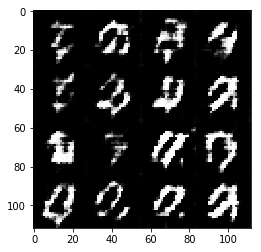

Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.4050
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 0.8324... Generator Loss: 1.4253
Epoch 1/2... Discriminator Loss: 1.7376... Generator Loss: 4.0292
Epoch 1/2... Discriminator Loss: 0.7275... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 2.5382... Generator Loss: 4.5284
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.6780... Generator Loss: 3.8754
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.6391


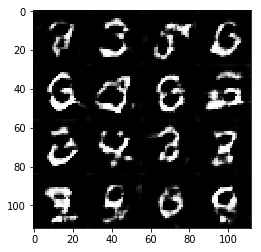

Epoch 1/2... Discriminator Loss: 0.4699... Generator Loss: 1.6379
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.0945
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.2281
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.5971
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.6625


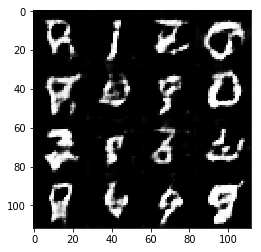

Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 1.5955
Epoch 1/2... Discriminator Loss: 2.6496... Generator Loss: 0.1739
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.2374
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 1.7789
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 1.9880
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.5332


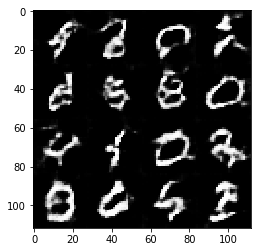

Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 2.2346
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 1.5172
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.8605


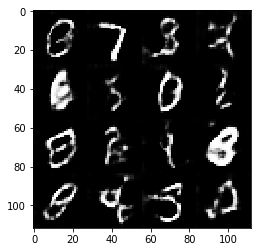

Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.7636
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.8543
Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 2.4941
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 2.0383
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 0.9603
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 1.6387
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.6126
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 1.7450


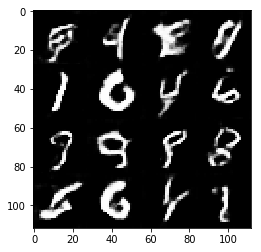

Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 1.2353
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.1940... Generator Loss: 0.5614
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 1.2211
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 1.2743


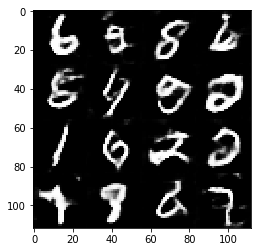

Epoch 2/2... Discriminator Loss: 1.5064... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 1.3224
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.6425... Generator Loss: 0.3088
Epoch 2/2... Discriminator Loss: 1.5905... Generator Loss: 0.3502
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 1.2508


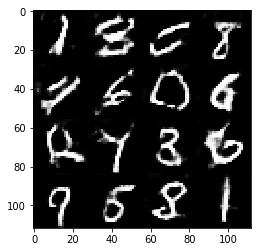

Epoch 2/2... Discriminator Loss: 2.2224... Generator Loss: 0.1762
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 0.7296


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 0.2445... Generator Loss: 1.8598
Epoch 1/1... Discriminator Loss: 0.1099... Generator Loss: 2.9183
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 8.3580
Epoch 1/1... Discriminator Loss: 1.8199... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 0.2752... Generator Loss: 1.9693
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 2.3714
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 2.2620
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 3.3715


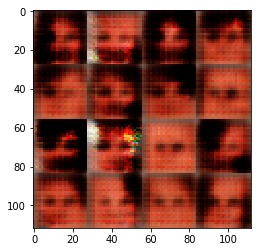

Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 2.4797
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.2884
Epoch 1/1... Discriminator Loss: 2.0101... Generator Loss: 3.4932
Epoch 1/1... Discriminator Loss: 0.0859... Generator Loss: 3.4515
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.2573... Generator Loss: 2.0545
Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 3.6646
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 2.0065
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.1087


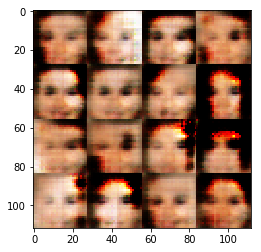

Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 3.4628... Generator Loss: 0.0571
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 2.3265
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.4066
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 2.6331
Epoch 1/1... Discriminator Loss: 0.2920... Generator Loss: 4.3741
Epoch 1/1... Discriminator Loss: 2.1568... Generator Loss: 0.1934


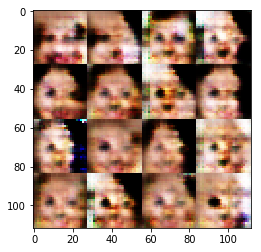

Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 0.2903... Generator Loss: 2.2592
Epoch 1/1... Discriminator Loss: 1.7941... Generator Loss: 3.7569
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 3.7559
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 3.1155
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 3.4930
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 0.1412... Generator Loss: 3.0604
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 5.8892
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.2366


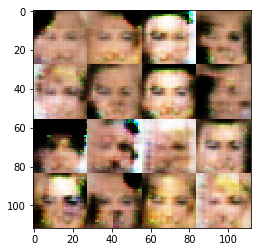

Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.3141
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 2.1552... Generator Loss: 0.1786
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 4.0046
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 4.6149
Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 2.9416
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 2.5487
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 0.2793... Generator Loss: 4.4520
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.6506


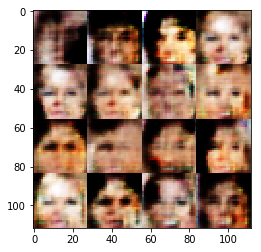

Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 3.7650
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 5.3212
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.1616... Generator Loss: 2.8323
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 2.9333
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 0.4179... Generator Loss: 2.8606


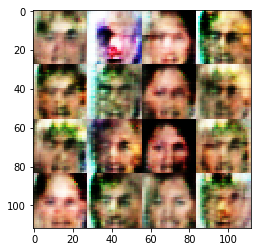

Epoch 1/1... Discriminator Loss: 3.4190... Generator Loss: 5.9716
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 4.4581
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 5.5129
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.8390
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 3.0621... Generator Loss: 0.1075
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 3.2754
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 6.0303


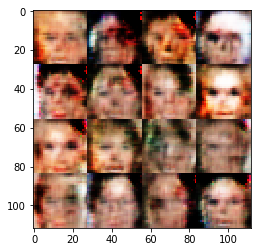

Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 3.3687
Epoch 1/1... Discriminator Loss: 0.1964... Generator Loss: 3.2155
Epoch 1/1... Discriminator Loss: 0.1526... Generator Loss: 6.4347
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 4.5004
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 0.3251... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.0786... Generator Loss: 3.5048
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.6053
Epoch 1/1... Discriminator Loss: 0.2877... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 1.9147... Generator Loss: 0.3452


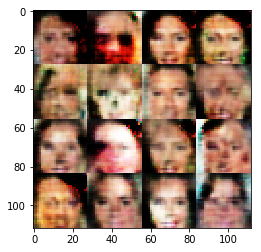

Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.9358
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 4.0527
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 3.6326
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.9033
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 2.7578
Epoch 1/1... Discriminator Loss: 0.2962... Generator Loss: 1.8838
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 3.8005


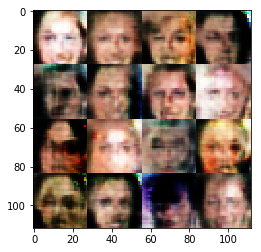

Epoch 1/1... Discriminator Loss: 0.1661... Generator Loss: 3.0114
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 2.9760
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 1.8522
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 2.3023
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.8378
Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 1.6654
Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 2.5247
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 4.3611


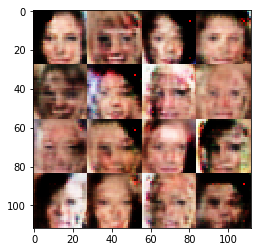

Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 0.2323... Generator Loss: 4.7947
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 2.1261
Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 4.0352
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 2.4668
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.5379
Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 4.4534


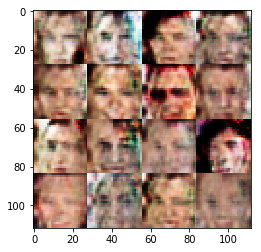

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 5.1987
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 3.2661
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 2.1976... Generator Loss: 8.3144
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.1174
Epoch 1/1... Discriminator Loss: 1.6410... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 1.8317
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 2.4262
Epoch 1/1... Discriminator Loss: 2.0430... Generator Loss: 5.8583


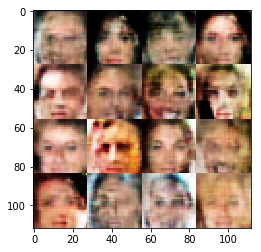

Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 1.6691
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 3.1657
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 2.5029
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 1.8669
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 3.2179
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 4.6964
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 0.9057


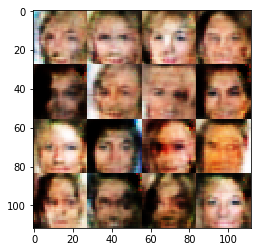

Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.8209... Generator Loss: 0.2989
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 1.7941... Generator Loss: 4.7828
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 2.4343
Epoch 1/1... Discriminator Loss: 0.2853... Generator Loss: 3.9188
Epoch 1/1... Discriminator Loss: 1.9669... Generator Loss: 0.2603
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 2.5616
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 2.4817


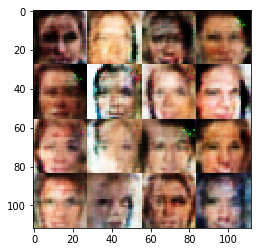

Epoch 1/1... Discriminator Loss: 0.3303... Generator Loss: 2.3280
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 2.1091
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 3.3767
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.7811
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 5.2891


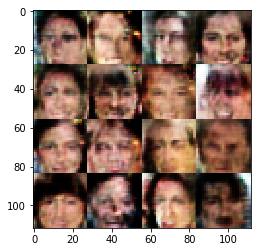

Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 4.8621
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 1.8966
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 2.6203
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.9425
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 2.2617


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.